In [1]:
import torch
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

def draw_pose(img, joints, joints_vis):
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    skelenton = [[10, 11], [11, 12], [12, 8], [8, 13], 
                 [13, 14], [14, 15], [8, 9], [7, 8], [2, 6],
                 [3, 6], [1, 2], [1, 0], [3, 4], [4, 5],[6,7]]
    for sk in skelenton:
        j1, j2 = joints[sk[0]], joints[sk[1]]
        if j1[0] > 0 and j1[1] > 0 and j2[0] > 0 and j2[1] > 0:
            ax.plot([j1[0], j2[0]], [j1[1], j2[1]], color='violet')
    # 画关节点, 可见点-红色, 遮挡点-蓝色
    markersize = (np.min((np.max(joints, axis=0) - np.min(joints, axis=0)) / np.array(img.shape)[:2])) * 5 + 2
    for i, joint in enumerate(joints):
        color = 'r' if joints_vis[i] > 0.0 else 'b'
        if joint[0] > 0.0 and joint[1] > 0.0:
            ax.plot(joint[0], joint[1], marker='o', mfc=color, mec=color, markersize=markersize)
#     plt.axis('off')
    plt.show()

In [2]:
def get_dict(batch_size=1):
    with open('/root/test-output-%d.obj' % batch_size, 'rb') as f:
        d = pickle.load(f)
    return d

def get_property(d):
    j = d['joints'].astype('int64')
    jp = d['joints_p'].astype('int64')
    jv = d['joints_vis'].astype('int64')
    input = d['input']
    output = d['output']
    target = d['target']
    target_weight = d['target_weight']
    return j, jp, jv, input, output, target, target_weight

In [3]:
d1 = get_dict(1)

In [4]:
d2 = get_dict(2)

In [5]:
d4 = get_dict(4)

In [6]:
d16 = get_dict(16)

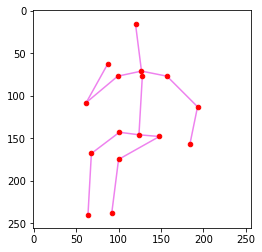

In [7]:
j1, jp1, jv1, inp1, oup1, gt1, tw1 = get_property(d1[0])
draw_pose(np.ones((256, 256, 3)), jp1, jv1)

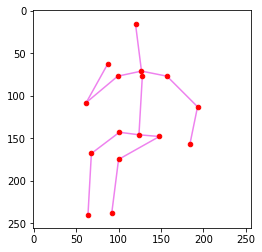

In [8]:
j2, jp2, jv2, inp2, oup2, gt2, tw2 = get_property(d2[0])
draw_pose(np.ones((256, 256, 3)), jp2, jv2)

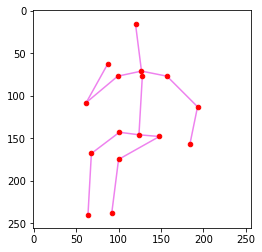

In [9]:
j4, jp4, jv4, inp4, oup4, gt4, tw4 = get_property(d4[0])
draw_pose(np.ones((256, 256, 3)), jp4, jv4)

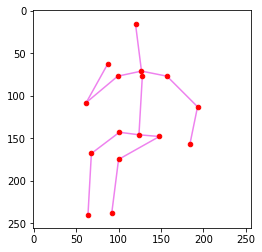

In [10]:
j16, jp16, jv16, inp16, oup16, gt16, tw16 = get_property(d16[0])
draw_pose(np.ones((256, 256, 3)), jp16, jv16)

In [11]:
def get_preds(scores):
    scores = scores[None, :]
    scores = torch.from_numpy(scores)
    assert scores.dim() == 4, 'Score maps should be 4-dim'
    # B x C x H x W -> B x C x HW, 取每张热图的最大概率值及所在索引位置
    maxval, idx = torch.max(scores.view(scores.size(0), scores.size(1), -1), 2)

    # maxval: B x C -> B x C x 1
    maxval = maxval.view(scores.size(0), scores.size(1), 1)
    # idx: B x C -> B x C x 1
    idx = idx.view(scores.size(0), scores.size(1), 1)

    # idx: B x C x 1 -> B x C x 2
    preds = idx.repeat(1, 1, 2).float()

    # 计算得到x坐标
    preds[:, :, 0] = (preds[:, :, 0]) % scores.size(3) + 1
    # 计算得到y坐标
    preds[:, :, 1] = torch.floor((preds[:, :, 1]) / scores.size(3)) + 1

    # 只有概率高于0的坐标才输出
    pred_mask = maxval.gt(0).repeat(1, 1, 2).float()
    preds *= pred_mask
    return preds[0]

In [73]:
p1 = get_preds(oup1)

In [61]:
p2 = get_preds(oup2)

In [63]:
p4 = get_preds(oup4)

In [64]:
p16 = get_preds(oup16)

#### 逐一比较各BatchSize预测结果

In [12]:
preds1 = {}
for k, v in d1.items():
    j1, jp1, jv1, inp1, oup1, gt1, tw1 = get_property(d1[k])
    preds1[k] = get_preds(oup1)

In [13]:
preds2 = {}
for k, v in d1.items():
    j2, jp2, jv2, inp2, oup2, gt2, tw2 = get_property(d2[k])
    preds2[k] = get_preds(oup2)

In [14]:
len(preds1), len(preds2)

(2958, 2958)

In [15]:
for i in range(len(preds1)):
    for j in range(len(preds1[i])):
        if preds1[i][j][0] != preds2[i][j][0] or preds1[i][j][1] != preds2[i][j][1]:
            print(preds1[i][j], '-', preds2[i][j])

**输出结果是一样的!!!**

#### 那是不是target_weight的问题

In [16]:
for k in range(2958):
    j1, jp1, jv1, inp1, oup1, gt1, tw1 = get_property(d1[k])
    j2, jp2, jv2, inp2, oup2, gt2, tw2 = get_property(d2[k])
    for j in range(16):
        if tw1[j] != tw2[j]:
            print(k, tw1, tw2)

**targe_weight也是一样的!!!**

#### target是不是一样?

In [17]:
gts1 = {}
for k, v in d1.items():
    j1, jp1, jv1, inp1, oup1, gt1, tw1 = get_property(d1[k])
    gts1[k] = get_preds(gt1)

In [18]:
gts2 = {}
for k, v in d1.items():
    j2, jp2, jv2, inp2, oup2, gt2, tw2 = get_property(d2[k])
    gts2[k] = get_preds(gt2)

In [19]:
for i in range(len(gts1)):
    for j in range(len(gts1[i])):
        if gts1[i][j][0] != gts2[i][j][0] or gts1[i][j][1] != gts2[i][j][1]:
            print(i)

**target也是一样的**

### 那问题只可能出在准确率计算部分

In [20]:
def calc_dists(pred, target):
    # preds: B x C x 2; target: B x C x 2
    if len(pred.shape) < 3:
        pred = pred[None, :]
        target = target[None, :]
    pred = pred.float()
    target = target.float()
    # dists: C x B
    dists = torch.zeros(pred.size(1), pred.size(0))
    # B x (h / 10)
    normalize = torch.ones(pred.size(0)) * 64 / 10
    # preds: B x C x 2;
    for b in range(pred.size(0)):
        for c in range(pred.size(1)):
            if target[b, c, 0] > 1 and target[b, c, 1] > 1:
                dists[c, b] = torch.dist(pred[b, c, :], target[b, c, :]) / normalize[b]
            else:
                dists[c, b] = -1
    return dists

In [21]:
for k in range(2958):
    dists1 = calc_dists(preds1[k], gts1[k])
    dists2 = calc_dists(preds2[k], gts2[k])
    for i in range(len(dists1)):
        if dists1[i] != dists2[i]:
            prnt(k, dists1[i], dists2[i])

**dists也是一样滴**

#### 最后一步统计准确率

In [22]:
# pckh0.5
def calc_dist_acc(dist, threshold=0.5):
    # dist == -1 即该关节点不在真值热图中或者是被遮挡的关节点, 不参与评估
    dist = dist[dist != -1]
    # dist: B,
    if len(dist) > 0:
        # 对于某个关节点，有B个输入，统计它的预测值和真值距离小于threshold的数量占总数的比例，得到这个关节点的pck
        return 1.0 * (dist < threshold).sum().item() / len(dist)
    else:
        return -1

In [23]:
# 平均准确率 以及 len(idx)个关节点的准确率
def get_avg_acc(pred, target):
    idx = list(range(16))
    
    # 平均准确率 以及 len(idx)个关节点的准确率
    acc = torch.zeros(1 + len(idx))
    avg_acc = 0
    cnt = 0
    
    dists = calc_dists(pred, target)
    for i in range(len(idx)):
        acc[i + 1] = calc_dist_acc(dists[idx[i]])
        if acc[i + 1] >= 0:
            avg_acc += acc[i + 1]
            cnt += 1
    if cnt != 0:
        acc[0] = avg_acc / cnt
    return acc

In [24]:
for k in range(2958):
    acc1 = get_avg_acc(preds1[k], gts1[k])[0].item()
    acc2 = get_avg_acc(preds2[k], gts2[k])[0].item()
    if acc1 != acc2:
        print(acc1, acc2)